In [7]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder

In [8]:
train_set = pd.read_csv('fashion-mnist_train.csv')
test_set = pd.read_csv('fashion-mnist_test.csv')

In [9]:
train_set.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [10]:
x_train = train_set.loc[:, train_set.columns != 'label'] 
x_test = test_set.loc[:, test_set.columns != 'label']
y_train = train_set['label']
y_test = test_set['label']

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [12]:
x_train /= 255
x_test /= 255

In [13]:
enc = OneHotEncoder()

In [14]:
y_train = enc.fit_transform(np.reshape(np.array(y_train), (-1,1))).toarray()
y_test = enc.transform(np.reshape(np.array(y_test), (-1,1))).toarray()

In [39]:
class SampleModel:
    def __init__(self, epochs, batch_size=None, verbose=0):
        self.epochs = epochs
        self.verbose = verbose
        self.batch_size = batch_size
        self.hist_df = pd.DataFrame()
        self.model = keras.models.Sequential()
        
    def add(self, layer_obj):
        self.model.add(layer_obj)

    def compile(self):
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=keras.optimizers.SGD(momentum=0.9),
                           metrics=['accuracy'],
                          )
        
    def fit(self, x, y, validation_data=None, callbacks=None):
        hist = self.model.fit(x, y,
                              batch_size=self.batch_size,
                              epochs=self.epochs,
                              verbose=self.verbose,
                              validation_data=validation_data,
                              callbacks=callbacks,
                            )
        self.hist_df = pd.DataFrame()
        for name in filter(lambda x: x in hist.history.keys(), ['accuracy', 'val_accuracy']):
            self.hist_df.insert(len(self.hist_df.columns), 
                                name, 
                                hist.history[name])
        if not self.hist_df.empty:
            self.hist_df.index +=1

    def accuracy(self, x, y, verbose=0):
        loss, accuracy = self.model.evaluate(x, y, verbose=0)
        if verbose:
            print('accuracy:', accuracy)
        else:
            return accuracy

In [40]:
def graph(df, title, x_axis=None):
    legend = ['Тренировочные данные', 'Тестовые данные']
    if x_axis is not None:
        df = df.loc[x_axis,]
    for name in filter(lambda x: x in df.columns, ['accuracy', 'val_accuracy']):
        plt.plot(df[name])
    plt.title(title)
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')
    plt.legend(legend)
    plt.show()        

In [41]:
def stop_callback():
    return keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

In [42]:
def tensorboard():
    return keras.callbacks.TensorBoard()

In [43]:
class Prop:
    num_classes = 10
    epochs=1000
    verbose=0

### <center>1. Логистическая регрессия

In [44]:
def gen_log_model(epochs, batch_size=None):
    model = SampleModel(epochs, batch_size=batch_size, verbose=Prop.verbose)
    model.add(keras.layers.Dense(Prop.num_classes, activation='softmax', input_shape=(784,)))
    model.compile()
    return model

In [45]:
log_model = gen_log_model(Prop.epochs)
log_model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              callbacks=[stop_callback(), tensorboard()]
             )
clear_output()
log_accuracy = log_model.accuracy(x_test, y_test)
print(f"accuracy: {log_accuracy}")

accuracy: 0.8561999797821045


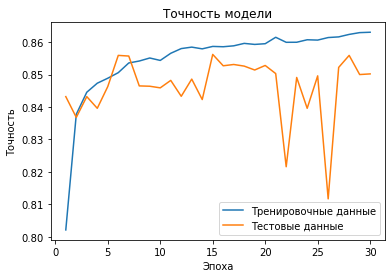

In [46]:
graph(log_model.hist_df, 'Точность модели')

### <center>2. Полносвязная нейронная сеть

In [47]:
def get_hopfield(epochs, batch_size=None):
    model = SampleModel(epochs, batch_size=batch_size)
    model.add(keras.layers.Dense(32, activation='relu', input_shape=(784,)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(Prop.num_classes, activation='softmax'))
    model.compile()
    return model

In [48]:
hopfield = get_hopfield(Prop.epochs)
hopfield.fit(x_train, y_train,
             validation_data=(x_test, y_test),
             callbacks=[stop_callback()]
            )
hopf_accuracy = hopfield.accuracy(x_test, y_test)
print(f"accuracy: {hopf_accuracy}")

accuracy: 0.8827000260353088


In [49]:
print(f"{log_accuracy:.2%} точность логистической регрессии")
print(f"{hopf_accuracy:.2%} точность полносвязной сети")

85.62% точность логистической регрессии
88.27% точность полносвязной сети


<b>Вывод:</b> Точность полносвязной сети должна превышать точность логистической регрессии, как минимум, потому, что полносвязная сеть представляет собой более сложную струкутуру, которая позволяет более точно вычислять весовые коэффициенты

### <center>3. Сверточная нейронная сеть

In [52]:
x_train_pixel = x_train.values.reshape(len(x_train), 28, 28, 1)
x_test_pixel  = x_test.values.reshape(len(x_test), 28, 28, 1)

In [55]:
def get_sub_layers(epochs, batch_size=None):
    model = SampleModel(epochs, batch_size=batch_size)
    model.add(keras.layers.Convolution2D(32, 
                                         kernel_size=(3,3), 
                                         input_shape=(28,28, 1),
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(Prop.num_classes, activation='softmax'))
    model.compile()
    return model

In [56]:
sub_layers = get_sub_layers(Prop.epochs)
sub_layers.fit(x_train_pixel, y_train,
               validation_data=(x_test_pixel, y_test),
               callbacks=[stop_callback()]
              )

sub_accuracy = sub_layers.accuracy(x_test_pixel, y_test)
print(f"accuracy: {sub_accuracy}")


accuracy: 0.9164000153541565


In [57]:
print(f"{hopf_accuracy:.2%} точность полносвязной сети")
print(f"{sub_accuracy:.2%} точность сверточной сети")

88.27% точность полносвязной сети
91.64% точность сверточной сети


<b>Вывод:</b> Добавление слоев субдискретизации позволило получить более точную модель при более простой структуре модели (по сложности вычислений в модели)

#### Увеличенное количество слоев

In [58]:
def get_sub_layers_big(epochs, batch_size=None):
    model = SampleModel(epochs, batch_size=batch_size)

    model.add(keras.layers.Convolution2D(32, 
                                         kernel_size=(3,3), 
                                         input_shape=(28,28, 1),
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Convolution2D(64, 
                                         kernel_size=(3,3), 
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Convolution2D(128, 
                                         kernel_size=(3,3), 
                                         activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(Prop.num_classes, activation='softmax'))
    model.compile()
    return model

In [59]:
sub_layers_big = get_sub_layers_big(Prop.epochs)
sub_layers_big.fit(x_train_pixel, y_train,
                   validation_data=(x_test_pixel, y_test),
                   callbacks=[stop_callback()]
                  )

subbig_accuracy = sub_layers_big.accuracy(x_test_pixel, y_test)
print(f"accuracy: {subbig_accuracy}")

accuracy: 0.8996000289916992


<b>Вывод:</b> Точность модели снизилась, возможно это связано с неверным выбором параметров модели

#### Добавление Batch Normalization слоев

In [60]:
def get_batch_norm(epochs, batch_size=None):
    model = SampleModel(epochs, batch_size=batch_size)

    model.add(keras.layers.Conv2D(32,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  activation='relu',
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  use_bias=False,
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  activation='relu',
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3), 
                                  input_shape=(28,28, 1),
                                  use_bias=False,
                                 ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32, activation='relu',use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(Prop.num_classes, activation='softmax'))
    model.compile()
    return model

In [61]:
batch_norm = get_batch_norm(Prop.epochs)
batch_norm.fit(x_train_pixel, y_train,
               validation_data=(x_test_pixel, y_test),
               callbacks=[stop_callback()]
              )

clear_output()
batch_norm_accuracy = batch_norm.accuracy(x_test_pixel, y_test)
print(f"accuracy: {batch_norm_accuracy}")


accuracy: 0.9380000233650208


#### Справка по всем моделям

In [63]:
print(f"{log_accuracy:.2%} точность логистической регрессии")
print(f"{hopf_accuracy:.2%} точность полносвязной сети")
print(f"{sub_accuracy:.2%} точность сверточной сети")
print(f"{subbig_accuracy:.2%} точность с увеличенным количеством слоев субдискретизации")
print(f"{batch_norm_accuracy:.2%} точность модели с batch-нормализацией")


85.62% точность логистической регрессии
88.27% точность полносвязной сети
91.64% точность сверточной сети
89.96% точность с увеличенным количеством слоев субдискретизации
93.80% точность модели с batch-нормализацией


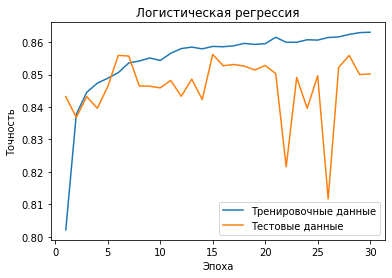

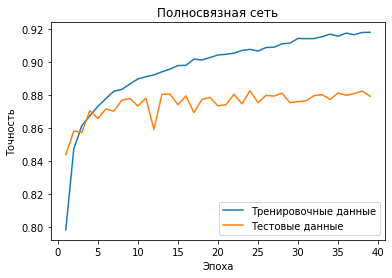

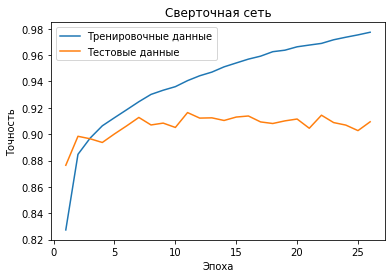

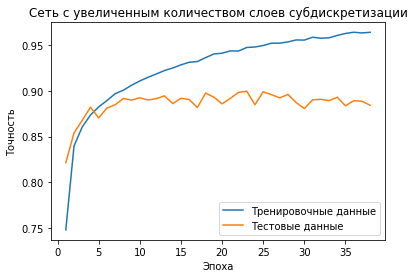

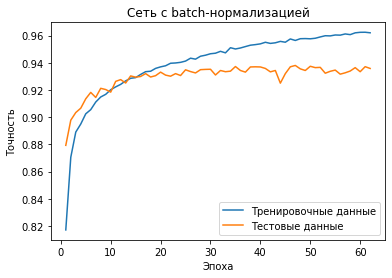

In [65]:
graph(log_model.hist_df, 'Логистическая регрессия')
graph(hopfield.hist_df, 'Полносвязная сеть')
graph(sub_layers.hist_df, 'Сверточная сеть')
graph(sub_layers_big.hist_df, 'Сеть с увеличенным количеством слоев субдискретизации')
graph(batch_norm.hist_df, 'Сеть с batch-нормализацией')